# X-Ray Image Classification

## Imports and Custom Functions

In [1]:

# Imports
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import PIL


from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import visualkeras as vk

import keras_tuner as kt
from keras_tuner import HyperParameters as hp

from sklearn.metrics import classification_report, ConfusionMatrixDisplay


# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)



In [2]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs


In [3]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)


In [4]:


def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



## PLOT_HISTORY FUNCTION FROM WEEK 3
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()



In [5]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict


## Upload and Check the Data

In [6]:
# Checking the contents of dataset folder
data_dir = "Data/xray-data"
data_dir


'Data/xray-data'

In [7]:
# Getting the list of folders in the data_dir
os.listdir(data_dir)


['covid', 'normal', 'pneumonia']

In [8]:
# Gettting the list of folders from data dir
subfolders = os.listdir(data_dir)
subfolders



['covid', 'normal', 'pneumonia']

In [9]:
# Getting list of all img file paths (ONLY, did not make recursive so no folders were included)
img_files = glob.glob(data_dir+"**/**/*")#, recursive=True)
len(img_files)


6939

In [10]:
# Take a look at the first 5 filepaths
img_files[-5:]


['Data\\xray-data\\pneumonia\\person997_virus_1678.jpeg',
 'Data\\xray-data\\pneumonia\\person998_bacteria_2927.jpeg',
 'Data\\xray-data\\pneumonia\\person998_bacteria_2928.jpeg',
 'Data\\xray-data\\pneumonia\\person9_bacteria_39.jpeg',
 'Data\\xray-data\\pneumonia\\person9_bacteria_41.jpeg']

In [11]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape



(751, 873, 3)

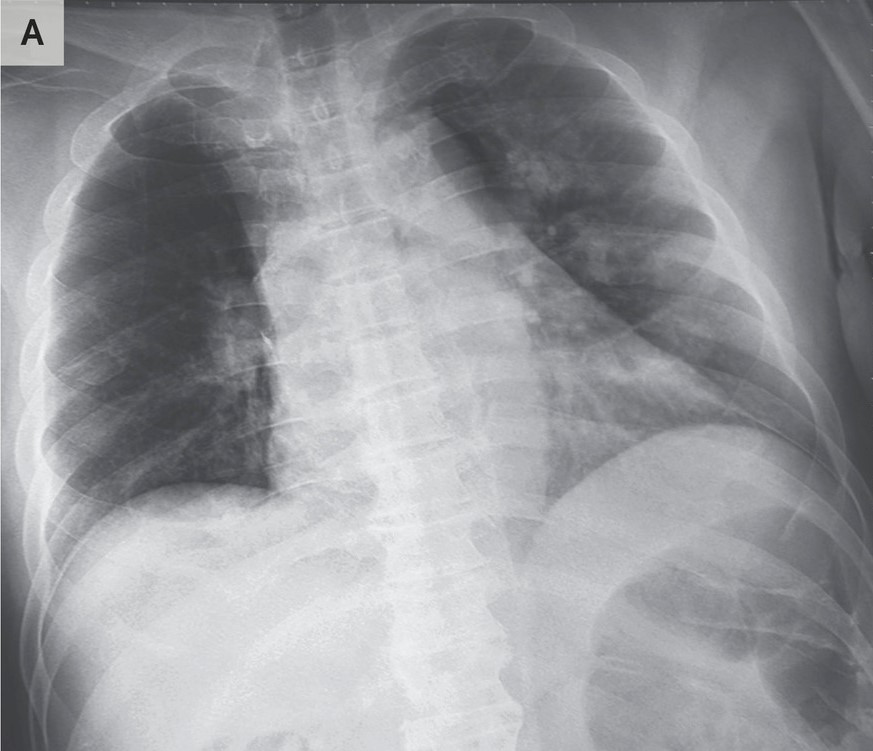

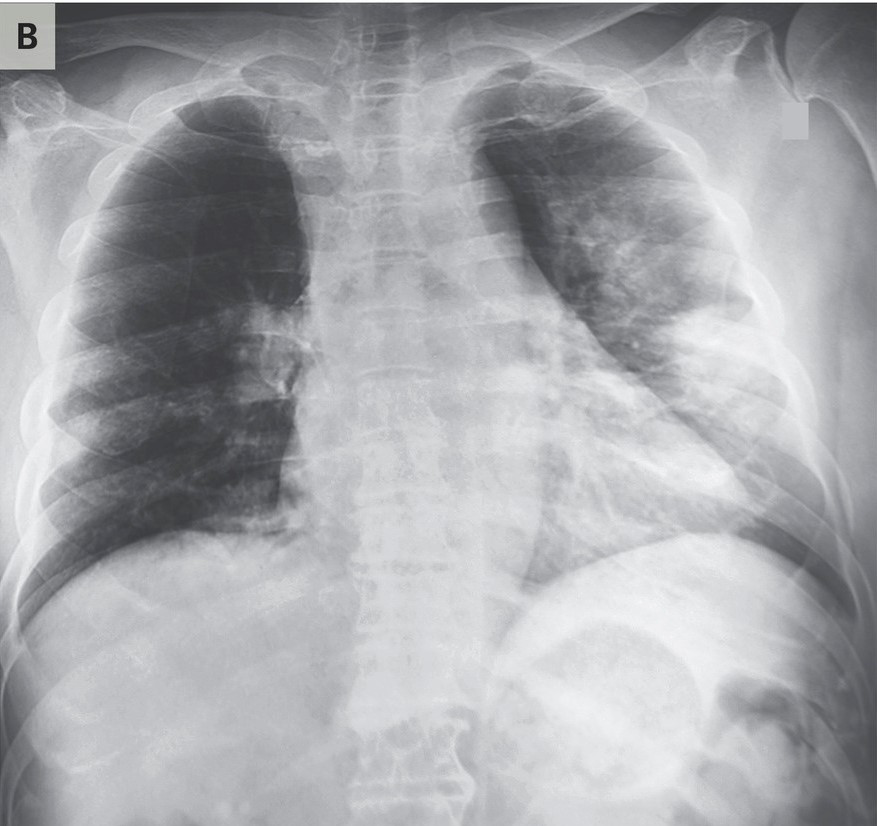

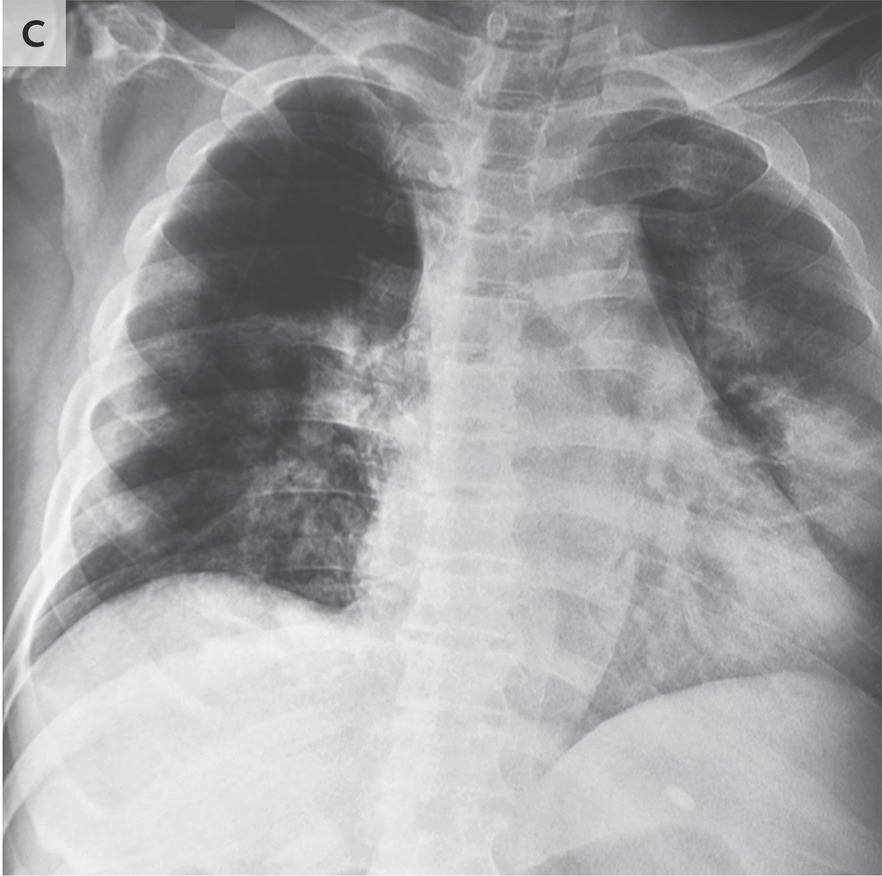

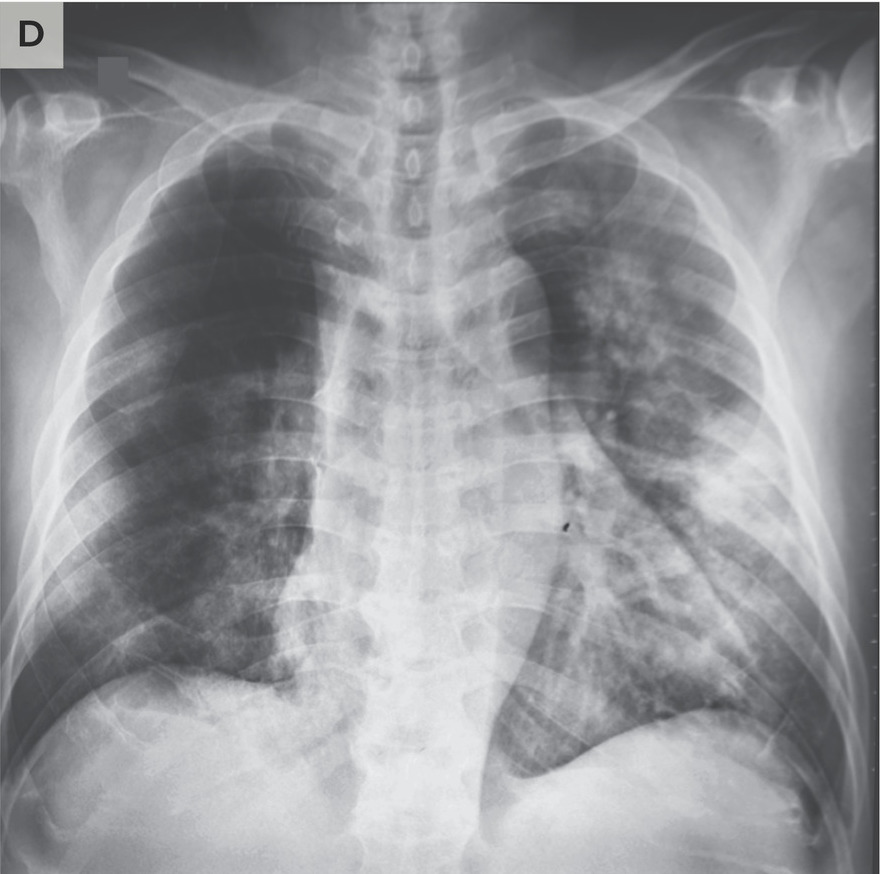

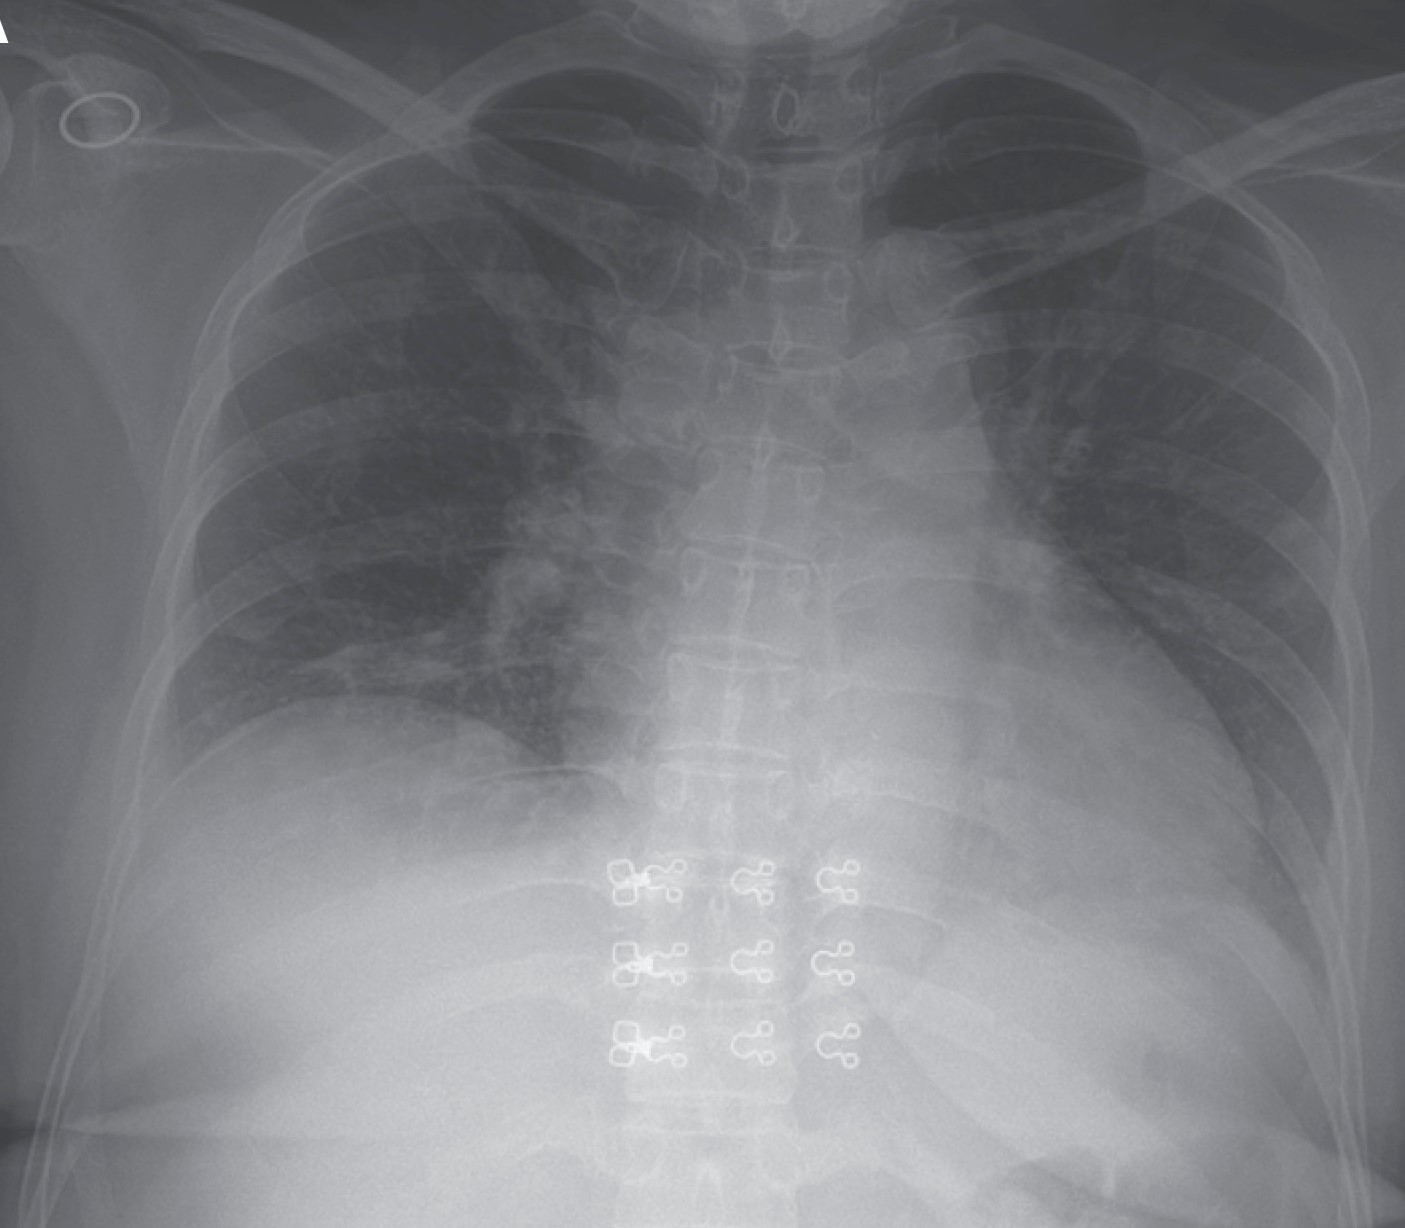

In [12]:
# load and view five images from the training images
for image in img_files[:5]:
    img_loaded = load_img(image)
    display(img_loaded)

## Tensorflow Image Dataset

In [13]:
# Saving image params as vars for reuse
batch_size = 128
img_height = 96
img_width = 96


In [14]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
ds


Found 6902 files belonging to 3 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [15]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size



54

In [17]:
# checking the class names
class_names = ds.class_names
class_names


['covid', 'normal', 'pneumonia']

In [18]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes



3

In [19]:
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes), class_names))
class_dict



{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [20]:
# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.2
split_test = .1 
# Calculate the number of batches for training and validation data 
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")


Use 37 batches as training data
Use 10 batches as validation data
The remaining 7 batches will be used as test data.


In [21]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)
# Confirm the length of the training set
len(train_ds)


37

In [22]:
# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
# Confirm the length of the validation set
len(val_ds)


10

In [23]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
# Confirm the length of the testing data
len(test_ds)


7

In [24]:
# The original (non-take/non-skip) dataset contains the class_names
class_names  = ds.class_names
class_names


['covid', 'normal', 'pneumonia']

## Optimize Dataset

In [25]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE



In [26]:
# Make buffer size the same as the number of batches in train_ds
buffer_size = len(train_ds)
buffer_size


37

In [27]:
# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size= buffer_size,
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Preview the Data

In [29]:
# Get one batch of images from the training set
example_imgs, example_labels= ds.take(1).get_single_element()
img = example_imgs[0]
label = example_labels[0]
input_shape = img.shape



normal


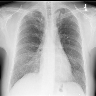

(96, 96, 3)


In [28]:
## Lookup the string name of the label and display both the label and the image
label = class_dict[np.argmax(label)]
print(label)
display(array_to_img(img))
print(input_shape)

# Modeling

## Simple CNN

In [30]:
def build_model1():
    
    model = models.Sequential(name="Model1")
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Convolutional layer #1
    model.add( layers.Conv2D(filters=16,  kernel_size=3, padding='same') ) 
    # Pooling layer #1
    model.add( layers.MaxPooling2D(pool_size=2, strides=1))
    
    # Convolutional layer #2
    model.add( layers.Conv2D(filters=16, kernel_size=3, padding='same')) 
    # Pooling layer #2
    model.add(layers.MaxPooling2D(pool_size=2, strides=1))
    
    # Flattening layer
    model.add(layers.Flatten())
    # # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")
    )
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    model.summary()
    return model

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 95, 95, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 94, 94, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 141376)            0    

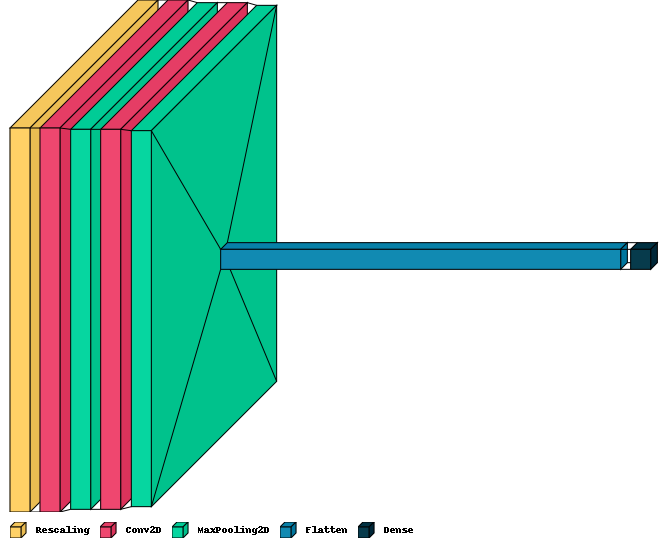

In [31]:
# Build model and visualize
model1 = build_model1()
vk.layered_view(model1, legend=True)

In [32]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]


In [33]:
# Build new model and fit 
model1 = build_model1()
history = model1.fit(
    train_ds, validation_data=val_ds, epochs=25, callbacks=get_callbacks()
)



Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 95, 95, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 94, 94, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 141376)            0    

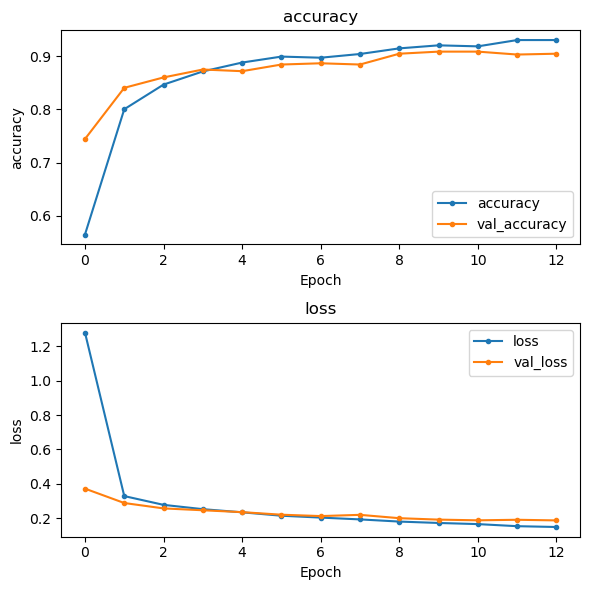


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1582
           1       0.88      0.98      0.92      1580
           2       0.97      0.92      0.95      1574

    accuracy                           0.94      4736
   macro avg       0.94      0.94      0.94      4736
weighted avg       0.94      0.94      0.94      4736



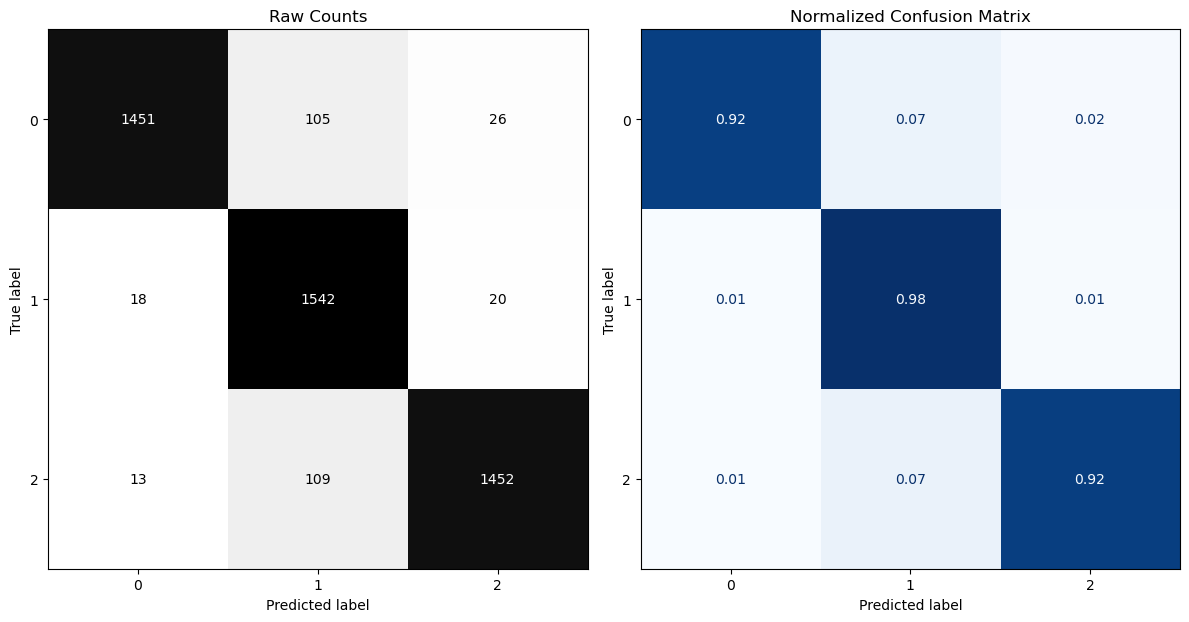


- Evaluating Training Data:
37/37 [==============================] - 3s 92ms/step - loss: 0.1411 - accuracy: 0.9386
{'loss': 0.14107702672481537, 'accuracy': 0.9385557174682617}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       268
           1       0.85      0.96      0.90       300
           2       0.96      0.88      0.92       318

    accuracy                           0.92       886
   macro avg       0.93      0.92      0.92       886
weighted avg       0.92      0.92      0.92       886



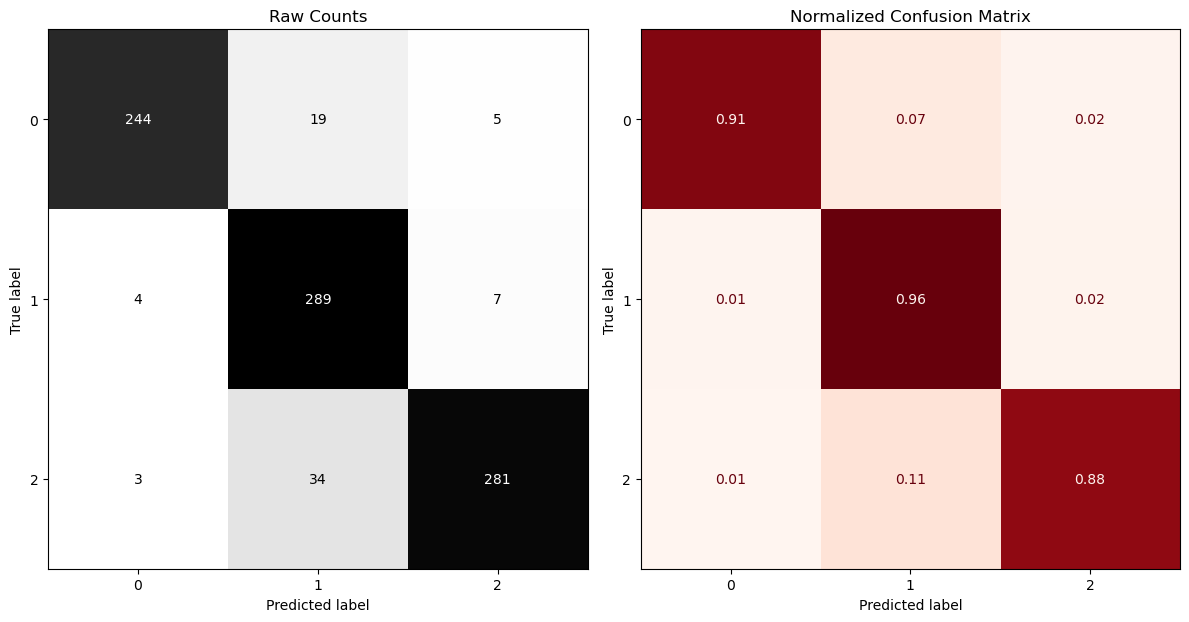


- Evaluating Test Data:
7/7 [==============================] - 1s 89ms/step - loss: 0.1832 - accuracy: 0.9187
{'loss': 0.18320541083812714, 'accuracy': 0.918735921382904}


In [35]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    model1, X_train=train_ds, X_test=test_ds, history=history, figsize=(12,8));

## Complex CNN

In [37]:
def build_model2():
    
    model = models.Sequential(name="Model2")
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Convolutional layer #1
    model.add( layers.Conv2D(filters=20,  kernel_size=3, padding='same') ) 
    model.add( layers.Conv2D(filters=20,  kernel_size=3, padding='same') ) 
    # Pooling layer #1
    model.add( layers.MaxPooling2D(pool_size=2, strides=1))
    
    # Convolutional layer #2
    model.add( layers.Conv2D(filters=20, kernel_size=3, padding='same')) 
    # Pooling layer #2
    model.add(layers.MaxPooling2D(pool_size=2, strides=1))
    
    # Flattening layer
    model.add(layers.Flatten())
    # # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")
    )
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [38]:
# Build model and visualize
model1 = build_model2()
vk.layered_view(model2, legend=True)

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 20)        560       
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 20)        3620      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 95, 95, 20)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 95, 95, 20)        3620      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 94, 94, 20)       0         
 2D)                                                        

NameError: name 'model2' is not defined

In [39]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]


In [40]:
# Build new model and fit 
model1 = build_model1()
history = model1.fit(
    train_ds, validation_data=val_ds, epochs=25, callbacks=get_callbacks()
)


Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 95, 95, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 95, 95, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 94, 94, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 141376)            0    

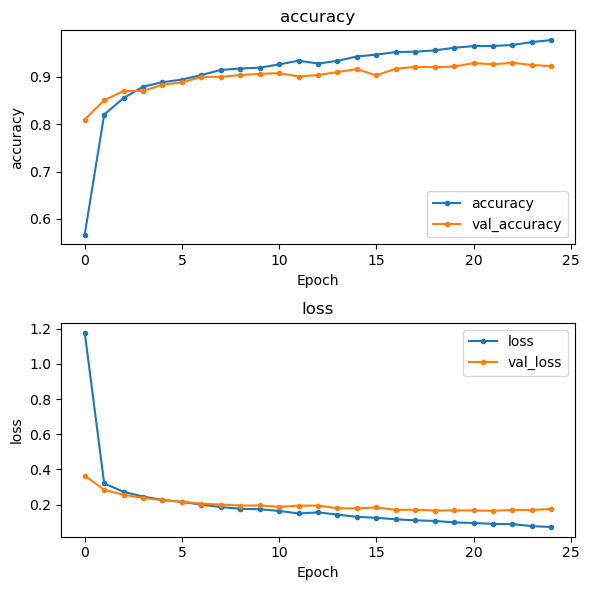


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1582
           1       0.96      0.99      0.97      1580
           2       0.98      0.97      0.98      1574

    accuracy                           0.98      4736
   macro avg       0.98      0.98      0.98      4736
weighted avg       0.98      0.98      0.98      4736



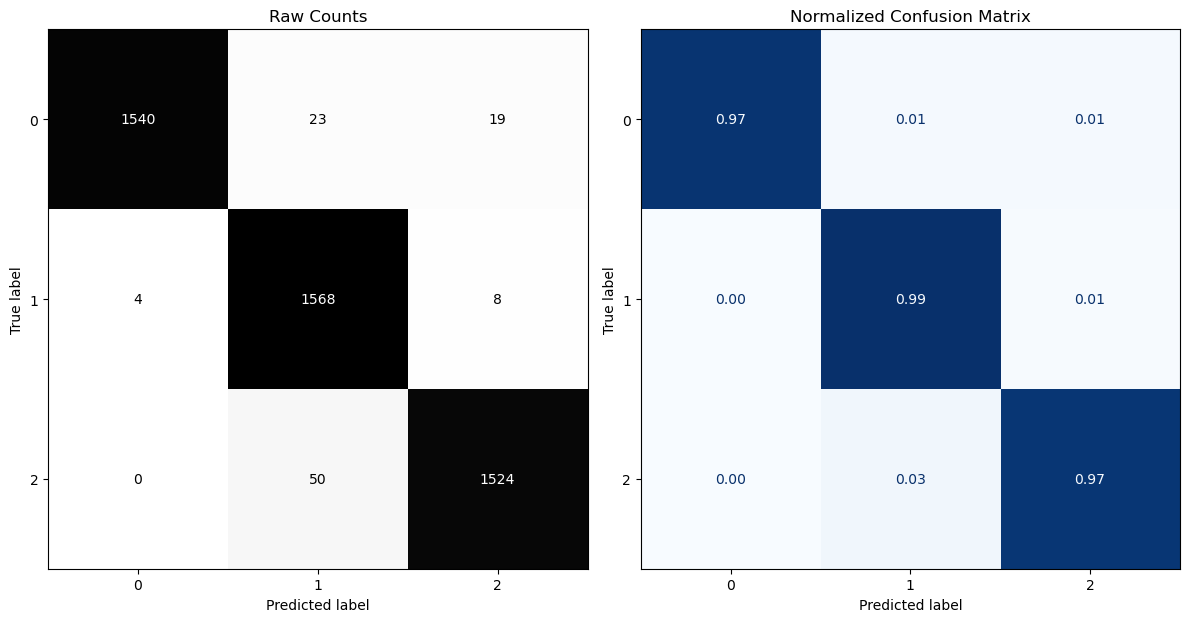


- Evaluating Training Data:
37/37 [==============================] - 4s 96ms/step - loss: 0.0684 - accuracy: 0.9780
{'loss': 0.06836199015378952, 'accuracy': 0.9780405163764954}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       268
           1       0.90      0.95      0.92       300
           2       0.94      0.92      0.93       318

    accuracy                           0.93       886
   macro avg       0.93      0.93      0.93       886
weighted avg       0.93      0.93      0.93       886



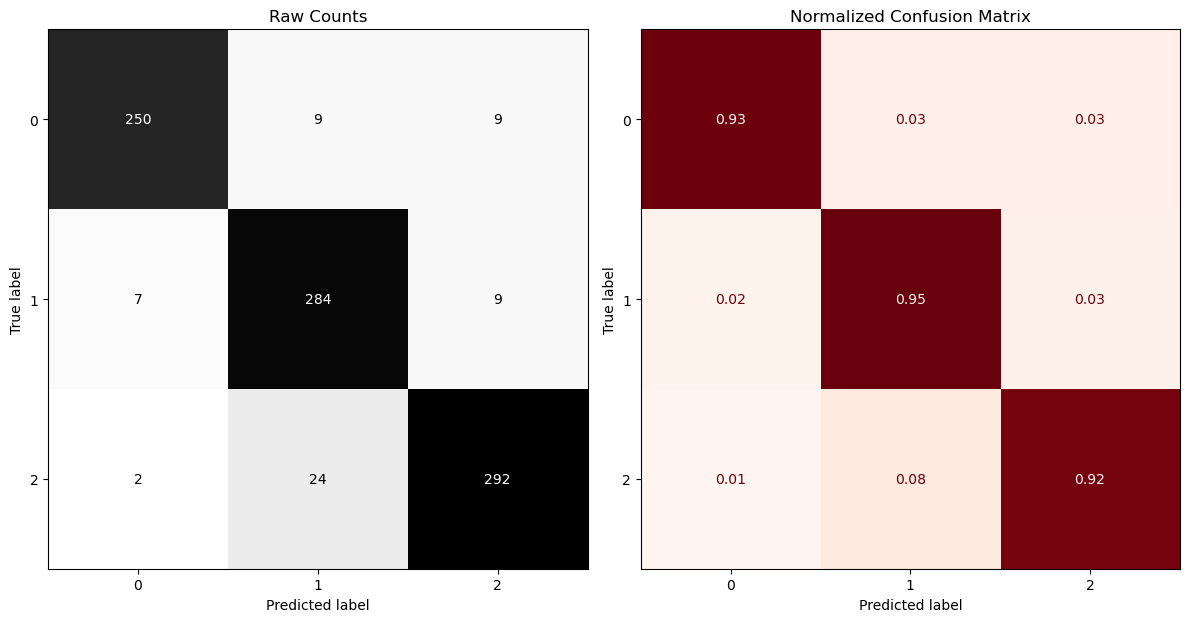


- Evaluating Test Data:
7/7 [==============================] - 1s 91ms/step - loss: 0.1644 - accuracy: 0.9323
{'loss': 0.1643858402967453, 'accuracy': 0.9322798848152161}


In [41]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    model1, X_train=train_ds, X_test=test_ds, history=history, figsize=(12,8));

## Transfer Learning

In [44]:
# Downloading just the convolutional base
vgg16_base = tf.keras.applications.VGG16(include_top = False, weights = 'imagenet', input_shape=input_shape)
vgg16_base.summary()



58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

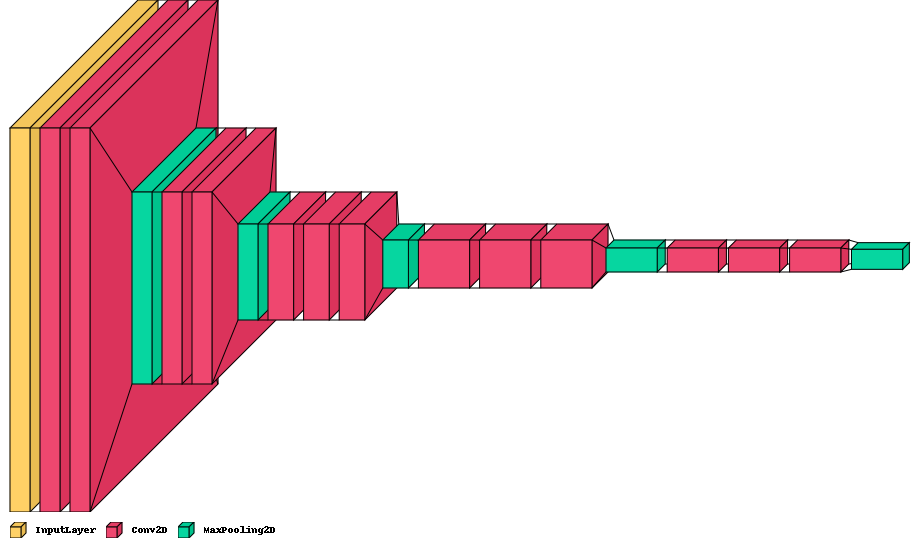

In [45]:
vk.layered_view(vgg16_base, legend=True)



In [46]:
# Downloading just the convolutional base
vgg16_base = tf.keras.applications.VGG16(
    include_top=False, weights="imagenet", input_shape=input_shape
)
# Prevent layers from base_model from changing 
vgg16_base.trainable = False

# Create the preprocessing lamdba layer
# Create a lambda layer for the preprocess input function for the model
lambda_layer_vgg16 = tf.keras.layers.Lambda(
    tf.keras.applications.vgg16.preprocess_input, name="preprocess_input"
)


def build_vgg16_model():
    model = models.Sequential(name="VGG16")
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_vgg16)

    # Add pretrained base
    model.add(vgg16_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(class_names), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model


In [47]:
def get_callbacks(monitor='val_accuracy', patience=3, restore_best_weights=False):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience, 
                                                      restore_best_weights=restore_best_weights)
    return [early_stopping]


In [48]:
model_vgg16 = build_vgg16_model()
model_vgg16.summary()


Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               1179904   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15,895,363
Trainable params: 1,180,675
Non-trai

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15,895,363
Trainable params: 1,180,675
Non-trai

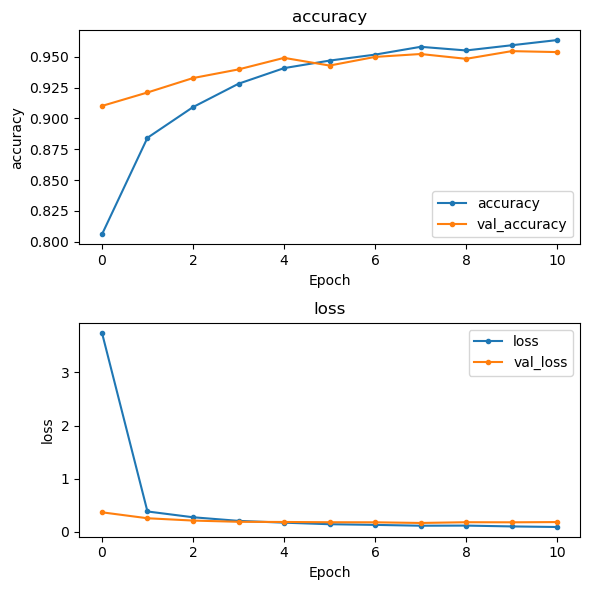


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       268
           1       0.90      0.98      0.94       300
           2       0.99      0.91      0.94       318

    accuracy                           0.95       886
   macro avg       0.95      0.95      0.95       886
weighted avg       0.95      0.95      0.95       886



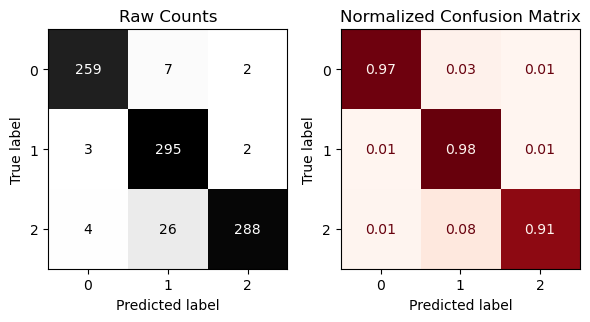


- Evaluating Test Data:
7/7 [==============================] - 9s 1s/step - loss: 0.2014 - accuracy: 0.9503
{'loss': 0.20140719413757324, 'accuracy': 0.95033860206604}


In [49]:
model_vgg16=build_vgg16_model()
history = model_vgg16.fit(train_ds, validation_data=val_ds,epochs=20, 
                    callbacks=get_callbacks()
                         )
evaluate_classification_network(model_vgg16,X_test=test_ds,history=history);

# Best Model

In [50]:
# Select the best model
best_model = model_vgg16 #model_effnet


In [51]:
# Create folder for best model
folder = 'BestModels/'
os.makedirs(folder, exist_ok=True)


In [52]:
# saving the best model
model_fname = 'BestModels/best-transfer-learning-to-explain.keras'
best_model.save(model_fname)


Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15,895,363
Trainable params: 1,180,675
Non-trai

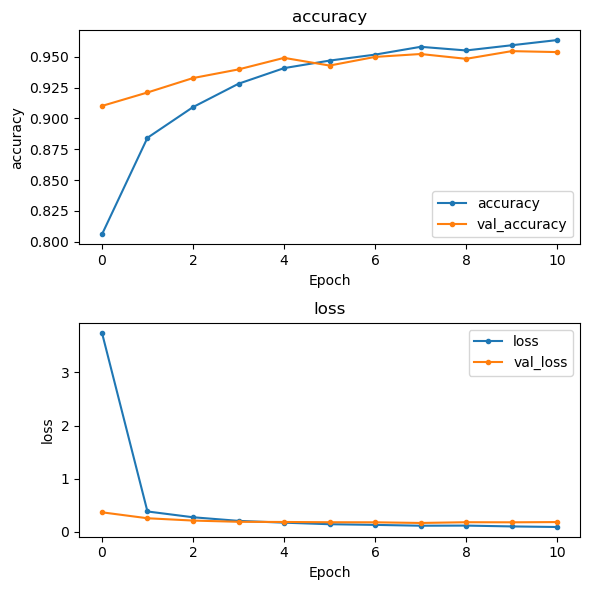


- Evaluating Network...


In [ ]:
loaded_model = tf.keras.models.load_model(model_fname)
loaded_model.summary()
evaluate_classification_network(loaded_model, X_test=test_ds, history=history);
